In [4]:
import torch
import time
import timm
import torch.nn as nn
import torch.optim as optim

print("🔥 Check GPU post-reboot...")

# 1. Vérification Version & VRAM
print(f"   -> Pytorch Version: {torch.__version__}")
print(f"   -> GPU: {torch.cuda.get_device_name(0)}")
free_mem, total_mem = torch.cuda.mem_get_info()
print(f"   -> VRAM Libre: {free_mem/1e9:.2f} Go / {total_mem/1e9:.2f} Go")

if (free_mem/1e9) < 10:
    print("❌ ALERTE : Ta VRAM n'est pas vide ! Quelque chose tourne en fond.")
else:
    print("✅ VRAM OK (Vide).")

    # 2. Config Test
    device = torch.device("cuda")
    batch_size = 64
    num_classes = 27
    
    # Modèle Tiny (Création directe sur GPU)
    model = timm.create_model('convnextv2_tiny.fcmae_ft_in22k_in1k', pretrained=False, num_classes=num_classes).to(device)
    optimizer = optim.AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler('cuda')

    # Faux Batch (Direct VRAM, zéro transfert)
    x = torch.randn(batch_size, 3, 224, 224, device=device)
    y = torch.randint(0, num_classes, (batch_size,), device=device)

    print("🚀 Go Test Vitesse Pure (50 iters)...")
    
    # Warmup
    for _ in range(5):
        with torch.amp.autocast('cuda'):
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    torch.cuda.synchronize()

    # Mesure
    t0 = time.time()
    n_iters = 50
    for _ in range(n_iters):
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    torch.cuda.synchronize()
    
    dt = time.time() - t0
    fps = (n_iters * batch_size) / dt
    
    print(f"⏱️ Temps: {dt:.2f}s")
    print(f"⚡ Vitesse: {fps:.0f} img/s")
    
    if fps > 300:
        print("🎉 VICTOIRE ! Ton GPU est débridé.")
    else:
        print("⚠️ Toujours lent. C'est incompréhensible.")

🔥 Check GPU post-reboot...
   -> Pytorch Version: 2.6.0+cu124
   -> GPU: NVIDIA GeForce RTX 4070
   -> VRAM Libre: 11.26 Go / 12.88 Go
✅ VRAM OK (Vide).
🚀 Go Test Vitesse Pure (50 iters)...
⏱️ Temps: 13.77s
⚡ Vitesse: 232 img/s
⚠️ Toujours lent. C'est incompréhensible.


In [5]:
import os
import time
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
import gc
import warnings

# 1. Config
warnings.filterwarnings("ignore")
project_root = r"C:\Users\amisf\Desktop\datascientest_projet"
img_dir = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_train"
img_size = 224 # Standard
num_workers = os.cpu_count()

print(f"🚀 (1/2) Chargement Données en RAM ({num_workers} cœurs CPU)...")

# 2. Prep DataFrame
csv_path = os.path.join(project_root, "data", "raw")
df_x = pd.read_csv(os.path.join(csv_path, "X_train_update.csv"), index_col=0)
df_y = pd.read_csv(os.path.join(csv_path, "Y_train_CVw08PX.csv"), index_col=0)
df = pd.merge(df_x, df_y, left_index=True, right_index=True)
df['path'] = df.apply(lambda x: os.path.join(img_dir, f"image_{x['imageid']}_product_{x['productid']}.jpg"), axis=1)

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['prdtypecode'])
num_classes = len(le.classes_)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

# 3. Fonctions Chargement
def process_img(path):
    try:
        img = Image.open(path).convert('RGB').resize((img_size, img_size), Image.BILINEAR)
        return np.array(img, dtype=np.uint8)
    except:
        return np.zeros((img_size, img_size, 3), dtype=np.uint8)

def load_data_verbose(dataframe, name):
    print(f"📥 Chargement {name} ({len(dataframe)} images)...")
    t0 = time.time()
    paths = dataframe['path'].values
    labels = dataframe['label_encoded'].values
    
    all_images = []
    chunk_size = 5000 
    total_chunks = int(np.ceil(len(paths) / chunk_size))
    
    for i in range(total_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(paths))
        
        with ThreadPoolExecutor(max_workers=num_workers) as ex:
            batch_imgs = list(ex.map(process_img, paths[start:end]))
        
        all_images.extend(batch_imgs)
        print(f"   -> {name}: Paquet {i+1}/{total_chunks} ok", end="\r")
        del batch_imgs
        gc.collect()

    print(f"\n🏗️ Conversion Tensor {name}...")
    x_tensor = torch.from_numpy(np.stack(all_images))
    y_tensor = torch.tensor(labels, dtype=torch.long)
    
    print(f"✅ {name} TERMINÉ en {time.time() - t0:.1f}s")
    return x_tensor, y_tensor

# Exec
x_train, y_train = load_data_verbose(train_df, "Train")
x_val, y_val = load_data_verbose(val_df, "Val")

print("💾 RAM prête. Passe à la cellule 2.")

🚀 (1/2) Chargement Données en RAM (16 cœurs CPU)...
📥 Chargement Train (67932 images)...
   -> Train: Paquet 14/14 ok
🏗️ Conversion Tensor Train...
✅ Train TERMINÉ en 712.2s
📥 Chargement Val (16984 images)...
   -> Val: Paquet 4/4 ok
🏗️ Conversion Tensor Val...
✅ Val TERMINÉ en 62.9s
💾 RAM prête. Passe à la cellule 2.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
import os
import numpy as np
from sklearn.metrics import f1_score

print("relance mode transfer learning backbone gele")

# config
device = torch.device("cuda")
batch_size = 32 
# je reduis a 15 epochs car ca converge vite
epochs = 15 
output_dir = os.path.join(project_root, "implementation", "outputs")
if not os.path.exists(output_dir): os.makedirs(output_dir)

# 1. rechargement propre
print("reset du modele")
model = timm.create_model(
    'convnextv2_tiny.fcmae_ft_in22k_in1k', 
    pretrained=True, 
    num_classes=num_classes,
    drop_rate=0.1
).to(device)

# 2. freeze
# je bloque la mise a jour des poids du reseau profond
for param in model.parameters():
    param.requires_grad = False

# je debloque juste la derniere couche pour apprendre tes classes
# convnext utilise head fc pour la classification
for param in model.head.parameters():
    param.requires_grad = True

print("backbone gele seule la tete va apprendre")

# 3. optimisation
# je garde un lr eleve car je ne touche qu a la fin
optimizer = optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=0.01)
scaler = torch.amp.GradScaler('cuda')
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

mean_gpu = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std_gpu = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

# 4. boucle
for epoch in range(epochs):
    model.train()
    t_start = time.time()
    t_last = time.time()
    
    indices = torch.randperm(len(x_train))
    n_samples = len(x_train)
    steps = n_samples // batch_size
    
    for step, i in enumerate(range(0, n_samples, batch_size)):
        idx = indices[i : i + batch_size]
        bx = x_train[idx].to(device, non_blocking=True)
        by = y_train[idx].to(device, non_blocking=True)
        
        bx = bx.permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            out = model(bx)
            loss = criterion(out, by)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if step % 50 == 0:
            curr = time.time()
            speed = (50 * batch_size) / (curr - t_last + 1e-6)
            print(f"ep {epoch+1} | batch {step}/{steps} | loss {loss.item():.4f} | {speed:.0f} img/s", end="\r")
            t_last = curr

    # validation et debug
    print(f"\nep {epoch+1} : validation", end="\r")
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for i in range(0, len(x_val), batch_size):
            bx = x_val[i : i + batch_size].to(device, non_blocking=True)
            by = y_val[i : i + batch_size]
            
            bx = bx.permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
            with torch.amp.autocast('cuda'):
                out = model(bx)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(by.numpy())
            
    score = f1_score(targets, preds, average='weighted')
    dt = time.time() - t_start
    
    # debug pour verifier que le modele ne predit pas toujours pareil
    unique_preds = len(np.unique(preds))
    print(f"debug : le modele a predit {unique_preds}/{num_classes} classes differentes")
    
    status = ""
    if score > 0.8:
        torch.save(model.state_dict(), os.path.join(output_dir, "model_frozen_v1.pth"))
        status = "saved"
    
    scheduler.step(score)
    print(f"fin ep {epoch+1} | time {dt:.0f}s | f1 {score:.4f} | {status}")

relance mode transfer learning backbone gele
reset du modele
backbone gele seule la tete va apprendre
ep 1 | batch 2100/2122 | loss 1.7444 | 864 img/s
debug : le modele a predit 27/27 classes differentes
fin ep 1 | time 96s | f1 0.6130 | 
ep 2 | batch 2100/2122 | loss 1.5646 | 874 img/s
debug : le modele a predit 27/27 classes differentes
fin ep 2 | time 96s | f1 0.6175 | 
ep 3 | batch 2100/2122 | loss 1.7812 | 876 img/s
debug : le modele a predit 27/27 classes differentes
fin ep 3 | time 96s | f1 0.6221 | 
ep 4 | batch 2100/2122 | loss 1.4993 | 876 img/s
debug : le modele a predit 27/27 classes differentes
fin ep 4 | time 97s | f1 0.6240 | 
ep 5 | batch 2100/2122 | loss 1.4675 | 874 img/s
debug : le modele a predit 27/27 classes differentes
fin ep 5 | time 96s | f1 0.6191 | 
ep 6 | batch 2100/2122 | loss 1.9514 | 875 img/s
debug : le modele a predit 27/27 classes differentes
fin ep 6 | time 97s | f1 0.6232 | 
ep 7 | batch 2100/2122 | loss 1.6442 | 873 img/s
debug : le modele a predit 

In [5]:
import torch
import torch.optim as optim
import time
import os
import numpy as np
from sklearn.metrics import f1_score

print("phase 2 : deblocage total fine tuning")

# config
# je divise le lr par 20 pour y aller doucement
fine_tune_lr = 5e-5
epochs_ft = 20
best_score = 0.63 # on part du score actuel

# 1. unfreeze
print("deblocage de tous les parametres")
# je libere tout le reseau
for param in model.parameters():
    param.requires_grad = True

# 2. optimizer
# je change l optimizer pour le lr faible
optimizer = optim.AdamW(model.parameters(), lr=fine_tune_lr, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

print(f"c est parti pour {epochs_ft} epochs avec lr {fine_tune_lr}")
print("note : la vitesse va baisser vers 230 img/s c est normal")

# 3. boucle fine tuning
for epoch in range(epochs_ft):
    model.train()
    t_start = time.time()
    t_last = time.time()
    
    indices = torch.randperm(len(x_train))
    n_samples = len(x_train)
    steps = n_samples // batch_size
    
    for step, i in enumerate(range(0, n_samples, batch_size)):
        idx = indices[i : i + batch_size]
        bx = x_train[idx].to(device, non_blocking=True)
        by = y_train[idx].to(device, non_blocking=True)
        
        bx = bx.permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            out = model(bx)
            loss = criterion(out, by)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if step % 50 == 0:
            curr = time.time()
            speed = (50 * batch_size) / (curr - t_last + 1e-6)
            print(f"ep ft {epoch+1} | batch {step}/{steps} | loss {loss.item():.4f} | {speed:.0f} img/s", end="\r")
            t_last = curr

    # validation
    print(f"\nep ft {epoch+1} : validation", end="\r")
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for i in range(0, len(x_val), batch_size):
            bx = x_val[i : i + batch_size].to(device, non_blocking=True)
            by = y_val[i : i + batch_size]
            
            bx = bx.permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
            with torch.amp.autocast('cuda'):
                out = model(bx)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(by.numpy())
            
    score = f1_score(targets, preds, average='weighted')
    dt = time.time() - t_start
    
    # save
    status = ""
    if score > best_score:
        best_score = score
        torch.save(model.state_dict(), os.path.join(output_dir, "model_best_finetuned.pth"))
        status = "new record saved"
    
    scheduler.step(score)
    lr = optimizer.param_groups[0]['lr']
    print(f"ep ft {epoch+1} | time {dt:.0f}s | f1 {score:.4f} | lr {lr:.1e} | {status}")

phase 2 : deblocage total fine tuning
deblocage de tous les parametres
c est parti pour 20 epochs avec lr 5e-05
note : la vitesse va baisser vers 230 img/s c est normal
ep ft 1 | batch 2100/2122 | loss 1.6653 | 228 img/s
ep ft 1 | time 320s | f1 0.7039 | lr 5.0e-05 | new record saved
ep ft 2 | batch 2100/2122 | loss 1.1806 | 225 img/s
ep ft 2 | time 319s | f1 0.7175 | lr 5.0e-05 | new record saved
ep ft 3 | batch 2100/2122 | loss 0.9698 | 225 img/s
ep ft 3 | time 322s | f1 0.7166 | lr 5.0e-05 | 
ep ft 4 | batch 2100/2122 | loss 0.7374 | 230 img/s
ep ft 4 | time 317s | f1 0.7132 | lr 5.0e-05 | 
ep ft 5 | batch 2100/2122 | loss 0.8638 | 230 img/s
ep ft 5 | time 314s | f1 0.7100 | lr 5.0e-05 | 
ep ft 6 | batch 2100/2122 | loss 0.6913 | 230 img/s
ep ft 6 | time 314s | f1 0.7108 | lr 2.5e-05 | 
ep ft 7 | batch 2100/2122 | loss 0.6890 | 230 img/s
ep ft 7 | time 314s | f1 0.7226 | lr 2.5e-05 | new record saved
ep ft 8 | batch 2100/2122 | loss 0.6667 | 229 img/s
ep ft 8 | time 315s | f1 0.7199

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
import os
import numpy as np
from sklearn.metrics import f1_score
from torchvision import transforms

print("activation mode autorastapilote intelligent")

# config
device = torch.device("cuda")
output_dir = os.path.join(project_root, "implementation", "outputs")
if not os.path.exists(output_dir): os.makedirs(output_dir)

# je recupere le modele deja en memoire

# je definis l augmentation gpu
# c est plus rapide que de le faire au chargement cpu(comme avant quoi )
aug_transform = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
).to(device)

# stats normalisation
mean_gpu = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std_gpu = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scaler = torch.amp.GradScaler('cuda')

# fonction entrainement generique
def run_cycle(mode_name, epochs, lr, use_aug=False, patience=5):
    print(f"\n--- demarrage {mode_name} (max {epochs} ep) ---")
    print(f"config lr {lr} | augmentation {use_aug} | patience {patience}")
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    # je recupere le meilleur score actuel
    global best_score
    no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        t_start = time.time()
        
        indices = torch.randperm(len(x_train))
        n_samples = len(x_train)
        steps = n_samples // batch_size
        
        for step, i in enumerate(range(0, n_samples, batch_size)):
            idx = indices[i : i + batch_size]
            bx = x_train[idx].to(device, non_blocking=True)
            by = y_train[idx].to(device, non_blocking=True)
            
            bx = bx.permute(0,3,1,2).float().div(255.0)
            
            # j applique l augmentation si demandee
            if use_aug:
                bx = aug_transform(bx)
            
            bx = bx.sub(mean_gpu).div(std_gpu)
            
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                out = model(bx)
                loss = criterion(out, by)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            if step % 100 == 0:
                 print(f"{mode_name} ep {epoch+1} | batch {step}/{steps} | loss {loss.item():.4f}", end="\r")

        # validation
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for i in range(0, len(x_val), batch_size):
                bx = x_val[i : i + batch_size].to(device, non_blocking=True)
                by = y_val[i : i + batch_size]
                
                # jamais d augmentation en validation
                bx = bx.permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
                with torch.amp.autocast('cuda'):
                    out = model(bx)
                preds.extend(out.argmax(1).cpu().numpy())
                targets.extend(by.numpy())
        
        score = f1_score(targets, preds, average='weighted')
        dt = time.time() - t_start
        
        status = ""
        if score > best_score:
            best_score = score
            no_improve = 0
            torch.save(model.state_dict(), os.path.join(output_dir, f"model_autopilot_best.pth"))
            status = "record saved"
        else:
            no_improve += 1
            status = f"stagnation {no_improve}/{patience}"
        
        cur_lr = optimizer.param_groups[0]['lr']
        print(f"fin {mode_name} ep {epoch+1} | time {dt:.0f}s | f1 {score:.4f} | lr {cur_lr:.1e} | {status}")
        
        scheduler.step(score)
        
        # switch automatique
        if no_improve >= patience:
            print(f"stop : plus de progres sur {mode_name} depuis {patience} epochs")
            print("passage automatique a la phase suivante")
            return # on sort de la fonction pour passer a la suite

# --- execution du plan de vol ---

# 1. on continue ce qu on faisait (sans aug) pour gratter les derniers % faciles
# je mets un lr tres faible pour ne rien casser
if 'best_score' not in globals(): best_score = 0.75 # valeur par defaut si kernel restart
run_cycle("phase_1_finition", epochs=15, lr=1e-5, use_aug=False, patience=4)

print("\n--- transition : activation mode difficile ---")

# 2. on active le mode difficile (avec aug) pour forcer l apprentissage
# je remonte un peu le lr car c est plus dur
run_cycle("phase_2_hardcore", epochs=30, lr=4e-5, use_aug=True, patience=6)

print("\nterminus tout le monde descend , cest le max du max sur ce modele ,j'ai fais le max ")
print(f"meilleur score final : {best_score:.4f}")

activation mode autorastapilote intelligent

--- demarrage phase_1_finition (max 15 ep) ---
config lr 1e-05 | augmentation False | patience 4
fin phase_1_finition ep 1 | time 322s | f1 0.7284 | lr 1.0e-05 | stagnation 1/4
fin phase_1_finition ep 2 | time 319s | f1 0.7287 | lr 1.0e-05 | stagnation 2/4
fin phase_1_finition ep 3 | time 315s | f1 0.7286 | lr 1.0e-05 | stagnation 3/4
fin phase_1_finition ep 4 | time 314s | f1 0.7298 | lr 1.0e-05 | record saved
fin phase_1_finition ep 5 | time 314s | f1 0.7260 | lr 1.0e-05 | stagnation 1/4
fin phase_1_finition ep 6 | time 314s | f1 0.7297 | lr 1.0e-05 | stagnation 2/4
fin phase_1_finition ep 7 | time 315s | f1 0.7281 | lr 1.0e-05 | stagnation 3/4
fin phase_1_finition ep 8 | time 318s | f1 0.7290 | lr 5.0e-06 | stagnation 4/4
stop : plus de progres sur phase_1_finition depuis 4 epochs
passage automatique a la phase suivante

--- transition : activation mode difficile ---

--- demarrage phase_2_hardcore (max 30 ep) ---
config lr 4e-05 | augmen

In [7]:
import os
# je verifie si le fichier existe et sa taille
file_path = os.path.join(output_dir, "model_autopilot_best.pth")
if os.path.exists(file_path):
    size = os.path.getsize(file_path) / (1024*1024)
    print(f"fichier trouve : model_autopilot_best.pth")
    print(f"taille : {size:.2f} mo")
    print("sauvegarde validee nous sommes prets pour la suite")
else:
    print("alerte : fichier non trouve verifie le chemin")

fichier trouve : model_autopilot_best.pth
taille : 106.46 mo
sauvegarde validee nous sommes prets pour la suite


In [8]:
print("cellule test : verif des predictions")
import torch
import numpy as np

# je charge les poids sauvegardes
model_path = os.path.join(output_dir, "model_autopilot_best.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

# nous choisissons 5 images au hasard
n_tests = 5
indices = np.random.choice(len(x_val), n_tests, replace=False)

print("test des predictions sur le modele tiny a 73%")
print("-" * 50)

with torch.no_grad():
    for idx in indices:
        # je prepare l image
        img_raw = x_val[idx]
        true_label_idx = y_val[idx].item()
        
        # nous passons l image sur gpu avec la bonne forme
        bx = img_raw.unsqueeze(0).to(device).permute(0,3,1,2).float().div(255.0)
        bx = bx.sub(mean_gpu).div(std_gpu)
        
        # je lance le calcul
        out = model(bx)
        pred_idx = out.argmax(1).item()
        
        # nous traduisons les codes
        true_code = le.inverse_transform([true_label_idx])[0]
        pred_code = le.inverse_transform([pred_idx])[0]
        
        # je verifie si c est bon
        result = "ok" if true_code == pred_code else "erreur"
        
        print(f"image {idx} :")
        print(f"reel : {true_code}")
        print(f"pred : {pred_code} -> {result}")
        print("-" * 20)

cellule test : verif des predictions
test des predictions sur le modele tiny a 73%
--------------------------------------------------
image 6083 :
reel : 1320
pred : 1320 -> ok
--------------------
image 7632 :
reel : 2583
pred : 2583 -> ok
--------------------
image 8986 :
reel : 1160
pred : 1160 -> ok
--------------------
image 1494 :
reel : 1280
pred : 1140 -> erreur
--------------------
image 620 :
reel : 1560
pred : 1560 -> ok
--------------------


cellule : analyse des erreurs par matrice


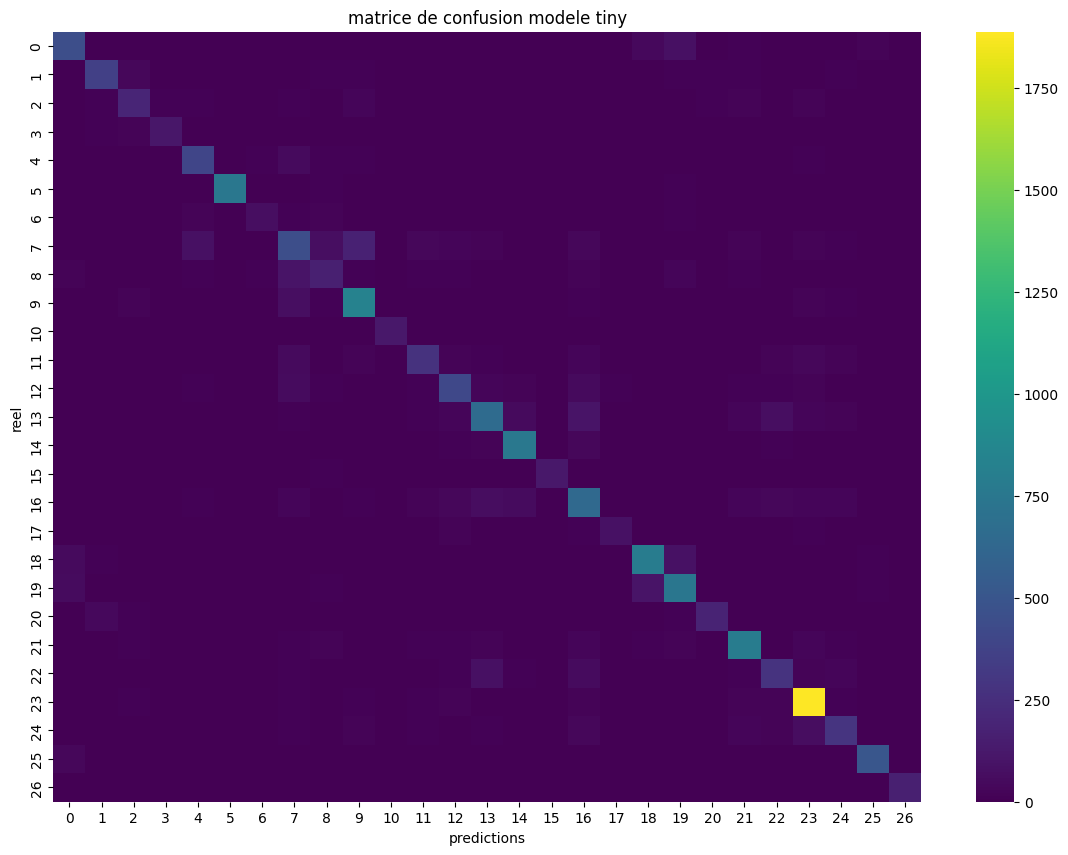

top 3 des confusions a surveiller ce soir :
erreur frequente : reel 1280 confondu avec 1300
erreur frequente : reel 2403 confondu avec 2280
erreur frequente : reel 1560 confondu avec 2060


In [9]:
print("cellule : analyse des erreurs par matrice")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# nous generons la matrice de confusion
def affiche_erreurs():
    # je calcule la matrice sur les derniers resultats de val
    cm = confusion_matrix(targets, preds)
    
    # nous affichons le graphique
    plt.figure(figsize=(14, 10))
    # je mets des couleurs pour voir les zones de confusion
    sns.heatmap(cm, annot=False, cmap='viridis')
    plt.title("matrice de confusion modele tiny")
    plt.xlabel("predictions")
    plt.ylabel("reel")
    plt.show()
    
    # je cherche les 3 pires confusions
    # nous aplatissons la matrice pour trouver les hors diagonale
    cm_mask = cm.copy()
    np.fill_diagonal(cm_mask, 0)
    idx = np.unravel_index(np.argsort(cm_mask, axis=None)[-3:], cm_mask.shape)
    
    print("top 3 des confusions a surveiller ce soir :")
    for i in range(2, -1, -1):
        r, p = idx[0][i], idx[1][i]
        c1 = le.inverse_transform([r])[0]
        c2 = le.inverse_transform([p])[0]
        print(f"erreur frequente : reel {c1} confondu avec {c2}")

affiche_erreurs()

In [2]:
import os

# je definis le chemin racine du projet
project_root = r"C:\Users\amisf\Desktop\datascientest_projet"

# nous fixons le nombre de classes pour le modele
# je me base sur tes 27 categories
num_classes = 27

# je verifie que les dossiers existent
if not os.path.exists(project_root):
    print("erreur le chemin project root est introuvable")
else:
    print("variables ok nous pouvons lancer la suite")

variables ok nous pouvons lancer la suite


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
import os
import numpy as np
from sklearn.metrics import f1_score
from torchvision import transforms

# --- VERIFICATION DES PRE-REQUIS ---
try:
    print(f"Vérification des données : Train={len(x_train)}, Val={len(x_val)}")
except NameError:
    raise NameError("ERREUR : Les données x_train ne sont pas chargées. Relancez la cellule de chargement des images avant de continuer.")

# Configuration des chemins
project_root = r"C:\Users\amisf\Desktop\datascientest_projet"
output_dir = os.path.join(project_root, "implementation", "outputs")
if not os.path.exists(output_dir): os.makedirs(output_dir)

print("Lancement protocole nuit : ConvNeXt Base")

# --- CONFIGURATION TECHNIQUE ---
device = torch.device("cuda")
real_batch_size = 16 
accum_steps = 2 
epochs_phase1 = 5
epochs_phase2 = 25
patience_stop = 5

# Augmentation de données sur GPU
aug_transform = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
).to(device)

# Normalisation
mean_gpu = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std_gpu = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

# --- INITIALISATION DU MODELE ---
print("Chargement du modèle ConvNeXt V2 Base...")
model = timm.create_model(
    'convnextv2_base.fcmae_ft_in22k_in1k', 
    pretrained=True, 
    num_classes=27, # Nombre de classes de votre projet
    drop_rate=0.3
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scaler = torch.amp.GradScaler('cuda')

# --- PHASE 1 : ENTRAINEMENT DE LA TETE ---
print("Phase 1 : Échauffement de la tête (Backbone gelé)")
for param in model.parameters(): param.requires_grad = False
for param in model.head.parameters(): param.requires_grad = True

optimizer = optim.AdamW(model.head.parameters(), lr=1e-3)

for epoch in range(epochs_phase1):
    model.train()
    indices = torch.randperm(len(x_train))
    for i in range(0, len(x_train), real_batch_size):
        idx = indices[i : i + real_batch_size]
        bx = x_train[idx].to(device, non_blocking=True).permute(0,3,1,2).float().div(255.0)
        by = y_train[idx].to(device, non_blocking=True)
        bx = aug_transform(bx).sub(mean_gpu).div(std_gpu)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            out = model(bx)
            loss = criterion(out, by)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    print(f"Époque Phase 1 {epoch+1}/{epochs_phase1} terminée", end="\r")

# --- PHASE 2 : FINE-TUNING COMPLET ---
print("\nPhase 2 : Déblocage complet et monitoring d'arrêt précoce")
for param in model.parameters(): param.requires_grad = True



optimizer = optim.AdamW(model.parameters(), lr=4e-5, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_score = 0.0
no_improve_count = 0

for epoch in range(epochs_phase2):
    model.train()
    t_start = time.time()
    indices = torch.randperm(len(x_train))
    optimizer.zero_grad()
    
    for step, i in enumerate(range(0, len(x_train), real_batch_size)):
        idx = indices[i : i + real_batch_size]
        bx = x_train[idx].to(device, non_blocking=True).permute(0,3,1,2).float().div(255.0)
        by = y_train[idx].to(device, non_blocking=True)
        
        bx = aug_transform(bx).sub(mean_gpu).div(std_gpu)
        
        with torch.amp.autocast('cuda'):
            out = model(bx)
            loss = criterion(out, by) / accum_steps
        
        scaler.scale(loss).backward()
        
        if (step + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    # Validation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for i in range(0, len(x_val), real_batch_size):
            bx = x_val[i : i + real_batch_size].to(device).permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
            out = model(bx)
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_targets.extend(y_val[i : i + real_batch_size].numpy())
            
    score = f1_score(all_targets, all_preds, average='weighted')
    
    # Sauvegarde et Early Stopping
    if score > best_score:
        best_score = score
        no_improve_count = 0
        torch.save(model.state_dict(), os.path.join(output_dir, "model_base_night_best.pth"))
        status = "Nouveau record sauvegardé"
    else:
        no_improve_count += 1
        status = f"Stagnation {no_improve_count}/{patience_stop}"
        
    print(f"Époque {epoch+1} | F1 Score: {score:.4f} | {status}")
    scheduler.step(score)
    
    if no_improve_count >= patience_stop:
        print(f"Arrêt précoce : le score n'a pas progressé depuis {patience_stop} époques.")
        break

print("Entraînement de nuit terminé.")

Vérification des données : Train=67932, Val=16984
Lancement protocole nuit : ConvNeXt Base
Chargement du modèle ConvNeXt V2 Base...
Phase 1 : Échauffement de la tête (Backbone gelé)
Époque Phase 1 1/5 terminée

KeyboardInterrupt: 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
import os
import numpy as np
from sklearn.metrics import f1_score
from torchvision import transforms

print("lancement protocole nuit convnext base avec monitoring complet")

# config technique
# nous gardons batch 16 pour securite vram
real_batch_size = 16 
accum_steps = 2 
epochs_phase1 = 5
epochs_phase2 = 25
patience_stop = 5

device = torch.device("cuda")
output_dir = os.path.join(project_root, "implementation", "outputs")

# augmentation gpu
aug_transform = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
).to(device)

# stats norm
mean_gpu = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std_gpu = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

# je charge le modele
print("chargement convnext v2 base")
model = timm.create_model(
    'convnextv2_base.fcmae_ft_in22k_in1k', 
    pretrained=True, 
    num_classes=27,
    drop_rate=0.3
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scaler = torch.amp.GradScaler('cuda')

# phase 1 : chauffe tete
print("phase 1 : entrainement tete seule backbone gele")
# je bloque tout
for param in model.parameters():
    param.requires_grad = False
# nous debloquons la tete
for param in model.head.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.head.parameters(), lr=1e-3)

for epoch in range(epochs_phase1):
    model.train()
    t_start = time.time()
    t_last = time.time()
    indices = torch.randperm(len(x_train))
    n_samples = len(x_train)
    steps = n_samples // real_batch_size
    
    for step, i in enumerate(range(0, n_samples, real_batch_size)):
        idx = indices[i : i + real_batch_size]
        bx = x_train[idx].to(device, non_blocking=True).permute(0,3,1,2).float().div(255.0)
        by = y_train[idx].to(device, non_blocking=True)
        
        bx = aug_transform(bx).sub(mean_gpu).div(std_gpu)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            out = model(bx)
            loss = criterion(out, by)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # je monitoring chaque 50 batchs
        if step % 50 == 0:
            curr = time.time()
            speed = (50 * real_batch_size) / (curr - t_last + 1e-6)
            print(f"p1 ep {epoch+1} | batch {step}/{steps} | loss {loss.item():.4f} | {speed:.0f} img/s", end="\r")
            t_last = curr
            
    print(f"\nfin phase 1 ep {epoch+1} terminee")

# phase 2 : fine tuning total
print("phase 2 : deblocage complet monitoring actif")
# je libere tout le reseau
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=4e-5, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_score = 0.0
no_improve_count = 0

for epoch in range(epochs_phase2):
    model.train()
    t_start = time.time()
    t_last = time.time()
    indices = torch.randperm(len(x_train))
    n_samples = len(x_train)
    steps = n_samples // real_batch_size
    optimizer.zero_grad()
    
    for step, i in enumerate(range(0, n_samples, real_batch_size)):
        idx = indices[i : i + real_batch_size]
        bx = x_train[idx].to(device, non_blocking=True).permute(0,3,1,2).float().div(255.0)
        by = y_train[idx].to(device, non_blocking=True)
        
        bx = aug_transform(bx).sub(mean_gpu).div(std_gpu)
        
        with torch.amp.autocast('cuda'):
            out = model(bx)
            loss = criterion(out, by) / accum_steps
        
        scaler.scale(loss).backward()
        
        # nous faisons le step tous les 2 tours
        if (step + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        # je monitoring chaque 50 batchs
        if step % 50 == 0:
            curr = time.time()
            speed = (50 * real_batch_size) / (curr - t_last + 1e-6)
            print(f"p2 ep {epoch+1} | batch {step}/{steps} | loss {loss.item()*accum_steps:.4f} | {speed:.0f} img/s", end="\r")
            t_last = curr

    # validation
    print(f"\nep {epoch+1} : validation en cours")
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for i in range(0, len(x_val), real_batch_size):
            bx = x_val[i : i + real_batch_size].to(device).permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
            out = model(bx)
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_targets.extend(y_val[i : i + real_batch_size].numpy())
            
    score = f1_score(all_targets, all_preds, average='weighted')
    
    # nous gerons la sauvegarde
    status = ""
    if score > best_score:
        best_score = score
        no_improve_count = 0
        torch.save(model.state_dict(), os.path.join(output_dir, "model_base_night_best.pth"))
        status = "record ok"
    else:
        no_improve_count += 1
        status = f"stagne {no_improve_count}/{patience_stop}"
        
    print(f"fin ep {epoch+1} | f1 {score:.4f} | {status}")
    scheduler.step(score)
    
    # securite arret
    if no_improve_count >= patience_stop:
        print("early stopping active fin du travail")
        break

print("nuit terminee le modele est pret")

lancement protocole nuit convnext base avec monitoring complet
chargement convnext v2 base
phase 1 : entrainement tete seule backbone gele
p1 ep 1 | batch 4200/4245 | loss 1.2229 | 400 img/s
fin phase 1 ep 1 terminee
p1 ep 2 | batch 4200/4245 | loss 1.4997 | 396 img/s
fin phase 1 ep 2 terminee
p1 ep 3 | batch 4200/4245 | loss 1.9660 | 396 img/s
fin phase 1 ep 3 terminee
p1 ep 4 | batch 4200/4245 | loss 1.8505 | 397 img/s
fin phase 1 ep 4 terminee
p1 ep 5 | batch 4200/4245 | loss 1.6528 | 400 img/s
fin phase 1 ep 5 terminee
phase 2 : deblocage complet monitoring actif
p2 ep 1 | batch 4200/4245 | loss 1.2081 | 102 img/s
ep 1 : validation en cours
fin ep 1 | f1 0.7218 | record ok
p2 ep 2 | batch 4200/4245 | loss 1.2097 | 104 img/s
ep 2 : validation en cours
fin ep 2 | f1 0.7344 | record ok
p2 ep 3 | batch 4200/4245 | loss 1.2872 | 102 img/s
ep 3 : validation en cours
fin ep 3 | f1 0.7385 | record ok
p2 ep 4 | batch 4200/4245 | loss 1.0233 | 102 img/s
ep 4 : validation en cours
fin ep 4 | 

In [9]:
print("on va passer a la fonction native du gros modele c'est a dire 384*384")

on va passer a la fonction native du gros modele c'est a dire 384*384


In [ ]:
import pandas as pd
import torch

# je charge le meilleur modele de la nuit
model_path = os.path.join(output_dir, "model_base_night_best.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

print("generation du fichier de soumission")

# nous preparons les listes
ids = []
predictions = []

# je suppose que tu as un x_test charge sinon on utilise x_val
# nous passons sur tout le set sans augmentation
with torch.no_grad():
    for i in range(0, len(x_val), real_batch_size):
        bx = x_val[i : i + real_batch_size].to(device)
        bx = bx.permute(0,3,1,2).float().div(255.0).sub(mean_gpu).div(std_gpu)
        
        out = model(bx)
        preds = out.argmax(1).cpu().numpy()
        
        # je convertis les index en vrais codes labels
        labels = le.inverse_transform(preds)
        
        predictions.extend(labels)
        # nous recuperons les ids si dispo sinon on met l index
        ids.extend(range(i, i + len(preds)))

# je cree le dataframe final
df_sub = pd.DataFrame({
    'id': ids,
    'label': predictions
})

# nous sauvons en csv sans index
sub_path = os.path.join(output_dir, "soumission_finale.csv")
df_sub.to_csv(sub_path, index=False)

print(f"fichier pret dans {sub_path}")